In [1]:
import os
import math
import mujoco
import numpy as np
import mediapy as media 
import matplotlib.pyplot as plt
import imageio.v3 as iio

In [2]:
ostrich_xml = """
<mujoco>
    <compiler angle="degree"/>
    
    <worldbody>
        <camera name="world" pos="4 -10 8" euler="60 0 0"/>
        
        <!-- Ground -->
        <geom mass="0.1" name="ramp" type="plane" pos="0 0 0" size="50 10 0.1" euler="0 0 0" rgba="0.7 0.7 .9 1" />
        
        <!-- Ostrich -->
        <body name="ostrich" pos="0 .2 0">

            <camera name="body_cam" mode="track" pos="0 -10 8" euler="60 0 0"/>

            
            <joint type="hinge" axis="1 0 0" range="-35 35"/>
            <joint type="hinge" axis="0 1 0" range="-45 45"/>
            <joint type="slide" axis="0 0 1"/>
            <joint type="slide" axis="0 1 0"/>
            <joint type="slide" axis="1 0 0"/>

            <!-- Rigid Body -->
            <geom mass="0.1" name="body" type="box" size="1.5 1.5 .5" pos="0 0 3.5" euler="0 0 0" rgba="0 1 0 1" contype="0"/>
            
            <geom mass="0.1"  name="rolling_leg_1" type="box" size=".1 .1 2" pos="-1.5 -1.5 2" rgba=".5 .2 .9 1" contype="0"/>
            <geom mass="0.5" name="wheel_1" type="sphere" size=".2" pos="-1.5 -1.5 0" friction="0" rgba=".2 .2 .5 1"/>
            
            <geom mass="0.1" name="rolling_leg_2" type="box" size=".1 .1 2" pos="-1.5 1.5 2" rgba=".5 .2 .9 1" contype="0"/>
            <geom mass="0.5" name="wheel_2" type="sphere" size=".2" pos="-1.5 1.5 0" friction="0" rgba=".2 .2 .5 1"/>

            <!-- Leg 1 -->
            
            <body name="l1" pos="1 -1.8 2.8" axisangle="0 1 0 30">
                <!-- Fixed Link -->
                <geom mass="0.1" type="box" size=".0005 .2 {fixed}" pos="0 0 0" contype="0" rgba=".1 .1 .1 1"/>

                <!-- Four Bar 1, "Knee" -->
                <body name="l1_b1_1" pos="0 0 {b1_1_b}" axisangle="0 1 0 {knee_angle}">
                    <joint name="j1_b1_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                    <geom mass="0.1" type="box" size=".0005 .2 {b1_1}" pos="0 0 {b1_1_pos}" rgba="1 0 0 1"/>

                    <body name="l1_b1_2" pos="0 0 {b1_2_b}" axisangle="0 1 0 90">
                        <joint name="j1_b1_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                        <geom mass="0.1" type="box" size=".0005 .2 {b1_2}" pos="0 0 {b1_2_pos}" rgba="0 0 1 1"/>

                        <body name="l1_b1_3" pos="0 0 {b1_3_b}" axisangle="0 1 0 90">
                            <joint name="j1_b1_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                            <geom mass="0.1" type="box" size=".0005 .2 {b1_3}" pos="0 0 {b1_3_pos}" rgba=".5 0 .5 1"/>
    
                            <body name="l1_b1_4" pos="0 0 {b1_4_b}" axisangle="0 1 0 90">
                                <joint name="j1_b1_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {b1_4}" pos="0 0 {b1_4_pos}" rgba="0 0 1 0"/>
                            
                            </body>                   
                        </body>
                    </body>
                </body>

                <!-- Four Bar 2, Ankle Transfer -->
                <body name="l1_b2_1" pos="0 0 {b2_1_b}" axisangle="0 1 0 {ankle_angle}">
                    <joint name="j1_b2_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                    <geom mass="0.1" type="box" size=".0005 .2 {b2_1}" pos="0 0 {b2_1_pos}" rgba="1 0 0 1"/>

                    <body name="l1_b2_2" pos="0 0 {b2_2_b}" axisangle="0 1 0 90">
                        <joint name="j1_b2_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                        <geom mass="0.1" type="box" size=".0005 .2 {b2_2}" pos="0 0 {b2_2_pos}" rgba=".5 .5 0 1"/>
                         
                         <body name="l1_b2_3" pos="0 0 {b2_3_b}" axisangle="0 1 0 90">
                            <joint name="j1_b2_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                            <geom mass="0.1" type="box" size=".0005 .2 {b2_3}" pos="0 0 {b2_3_pos}" rgba="0 1 0 1"/>
                            
                            <body name="l1_b2_4" pos="0 0 {b2_4_b}" axisangle="0 1 0 90">
                                <joint name="j1_b2_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {b2_4}" pos="0 0 {b2_4_pos}" rgba=".5 .5 0 0"/>
                            
                            </body> 
                        </body>

                        <!-- Transfer --> 
                        <body name="l1_t_1" pos="0 0 {t_1_b}" axisangle="0 1 0 0">
                            <joint name="j1_t_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                            <geom mass="0.1" type="box" size=".0005 .2 {t_1}" pos="0 0 {t_1_pos}" rgba="1 1 1 1"/>
                        
                            <body name="l1_t_2" pos="0 0 {t_2_b}" axisangle="0 1 0 90">
                                <joint name="j1_t_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {t_2}" pos="0 0 {t_2_pos}" rgba="1 1 1 1"/>
                            
                                <body name="l1_t_3" pos="0 0 {t_3_b}" axisangle="0 1 0 90">
                                    <joint name="j1_t_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                    <geom mass="0.1" type="box" size=".0005 .2 {t_3}" pos="0 0 {t_3_pos}" rgba="1 1 1 0"/>
                        
                                </body>
                            </body>

                            <!-- Four Bar 3, Ankle -->
                            <body name="l1_b3_1" pos="0 0 {b3_1_b}" axisangle="0 1 0 90">
                                <joint name="j1_b3_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {b3_1}" pos="0 0 {b3_1_pos}" rgba="0 .5 .5 1"/>

                                <body name="l1_b3_2" pos="0 0 {b3_2_b}" axisangle="0 1 0 90">
                                    <joint name="j1_b3_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                    <geom mass="0.1" type="box" size=".0005 .2 {b3_2}" pos="0 0 {b3_2_pos}" rgba="0 1 1 1"/>

                                    <!-- Foot -->
                                    <geom mass="0.1" type="box" size=".0005 .2 .6" pos="0 0 .2" friction=".36" rgba="1 1 1 1"/>

                                    <body name="l1_b3_3" pos="0 0 {b3_3_b}" axisangle="0 1 0 90">
                                        <joint name="j1_b3_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                        <geom mass="0.1" type="box" size=".0005 .2 {b3_3}" pos="0 0 {b3_3_pos}" rgba="1 0 1 1" contype="0"/>
                                        
                                    </body>
                                </body>
                            </body>
                            
                        </body>

                    </body>
                </body>
                
            </body>

            
           <!-- Leg 1 -->
            
            <body name="l2" pos="1 1.8 2.8" axisangle="0 1 0 30">
                <!-- Fixed Link -->
                <geom mass="0.1" type="box" size=".0005 .2 {fixed}" pos="0 0 0" contype="0" rgba=".1 .1 .1 1"/>

                <!-- Four Bar 1, "Knee" -->
                <body name="l2_b1_1" pos="0 0 {b1_1_b}" axisangle="0 1 0 {knee_angle}">
                    <joint name="j2_b1_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                    <geom mass="0.1" type="box" size=".0005 .2 {b1_1}" pos="0 0 {b1_1_pos}" rgba="1 0 0 1"/>

                    <body name="l2_b1_2" pos="0 0 {b1_2_b}" axisangle="0 1 0 90">
                        <joint name="j2_b1_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                        <geom mass="0.1" type="box" size=".0005 .2 {b1_2}" pos="0 0 {b1_2_pos}" rgba="0 0 1 1"/>

                        <body name="l2_b1_3" pos="0 0 {b1_3_b}" axisangle="0 1 0 90">
                            <joint name="j2_b1_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                            <geom mass="0.1" type="box" size=".0005 .2 {b1_3}" pos="0 0 {b1_3_pos}" rgba=".5 0 .5 1"/>
    
                            <body name="l2_b1_4" pos="0 0 {b1_4_b}" axisangle="0 1 0 90">
                                <joint name="j2_b1_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {b1_4}" pos="0 0 {b1_4_pos}" rgba="0 0 1 0"/>
                            
                            </body>                   
                        </body>
                    </body>
                </body>

                <!-- Four Bar 2, Ankle Transfer -->
                <body name="l2_b2_1" pos="0 0 {b2_1_b}" axisangle="0 1 0 {ankle_angle}">
                    <joint name="j2_b2_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                    <geom mass="0.1" type="box" size=".0005 .2 {b2_1}" pos="0 0 {b2_1_pos}" rgba="1 0 0 1"/>

                    <body name="l2_b2_2" pos="0 0 {b2_2_b}" axisangle="0 1 0 90">
                        <joint name="j2_b2_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                        <geom mass="0.1" type="box" size=".0005 .2 {b2_2}" pos="0 0 {b2_2_pos}" rgba=".5 .5 0 1"/>
                         
                         <body name="l2_b2_3" pos="0 0 {b2_3_b}" axisangle="0 1 0 90">
                            <joint name="j2_b2_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                            <geom mass="0.1" type="box" size=".0005 .2 {b2_3}" pos="0 0 {b2_3_pos}" rgba="0 1 0 1"/>
                            
                            <body name="l2_b2_4" pos="0 0 {b2_4_b}" axisangle="0 1 0 90">
                                <joint name="j2_b2_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {b2_4}" pos="0 0 {b2_4_pos}" rgba=".5 .5 0 0"/>
                            
                            </body> 
                        </body>

                        <!-- Transfer --> 
                        <body name="l2_t_1" pos="0 0 {t_1_b}" axisangle="0 1 0 0">
                            <joint name="j2_t_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/> 
                            <geom mass="0.1" type="box" size=".0005 .2 {t_1}" pos="0 0 {t_1_pos}" rgba="1 1 1 1"/>
                        
                            <body name="l2_t_2" pos="0 0 {t_2_b}" axisangle="0 1 0 90">
                                <joint name="j2_t_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {t_2}" pos="0 0 {t_2_pos}" rgba="1 1 1 1"/>
                            
                                <body name="l2_t_3" pos="0 0 {t_3_b}" axisangle="0 1 0 90">
                                    <joint name="j2_t_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                    <geom mass="0.1" type="box" size=".0005 .2 {t_3}" pos="0 0 {t_3_pos}" rgba="1 1 1 0"/>
                        
                                </body>
                            </body>

                            <!-- Four Bar 3, Ankle -->
                            <body name="l2_b3_1" pos="0 0 {b3_1_b}" axisangle="0 1 0 90">
                                <joint name="j2_b3_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size=".0005 .2 {b3_1}" pos="0 0 {b3_1_pos}" rgba="0 .5 .5 1"/>

                                <body name="l2_b3_2" pos="0 0 {b3_2_b}" axisangle="0 1 0 90">
                                    <joint name="j2_b3_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                    <geom mass="0.1" type="box" size=".0005 .2 {b3_2}" pos="0 0 {b3_2_pos}" rgba="0 1 1 1"/>

                                    <!-- Foot -->
                                    <geom mass="0.1" type="box" size=".0005 .2 .6" pos="0 0 .2" friction=".36" rgba="1 1 1 1"/>

                                    <body name="l2_b3_3" pos="0 0 {b3_3_b}" axisangle="0 1 0 90">
                                        <joint name="j2_b3_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                        <geom mass="0.1" type="box" size=".0005 .2 {b3_3}" pos="0 0 {b3_3_pos}" rgba="1 0 1 1" contype="0"/>
                                        
                                    </body>
                                </body>
                            </body>
                            
                        </body>

                    </body>
                </body>
                
            </body>
                        
        </body>
    </worldbody>

    <equality>
        <weld name="l1_4bar_1" active="true" body1="l1" body2="l1_b1_4" relpose="0 .025 -.4 1 0 0 0"/>
        <weld name="l1_4bar_2" active="true" body1="l1_b1_1" body2="l1_b2_4" relpose="0 0 2 0 0 1 0"/>
        <weld name="l1_t" active="true" body1="l1_b1_1" body2="l1_t_3" relpose="0 0 2 0 0 1 0"/>
        <weld name="l1_4bar_3" active="true" body1="l1_b3_3" body2="l1_b1_2" relpose="0 0 2 0 0 1 0"/>

        <weld name="l2_4bar_1" active="true" body1="l2" body2="l2_b1_4" relpose="0 .025 -.4 1 0 0 0"/>
        <weld name="l2_4bar_2" active="true" body1="l2_b1_1" body2="l2_b2_4" relpose="0 0 2 0 0 1 0"/>
        <weld name="l2_t" active="true" body1="l2_b1_1" body2="l2_t_3" relpose="0 0 2 0 0 1 0"/>
        <weld name="l2_4bar_3" active="true" body1="l2_b3_3" body2="l2_b1_2" relpose="0 0 2 0 0 1 0"/>

    </equality>

    <actuator>
        <position name="l1_servo1" joint="j1_b1_1" kp="200"/>
        <position name="l1_servo2" joint="j1_b2_1" kp="200"/>

        <position name="l2_servo1" joint="j2_b1_1" kp="200"/>
        <position name="l2_servo2" joint="j2_b2_1" kp="200"/>

    </actuator>
</mujoco>

"""

In [3]:
duration = 15
framerate = 30 
data_rate = 100

# Default gait offsets
off_set_between_legs = math.pi/3

p1_off = math.pi/4
p2_off = math.pi/3
p3_off = math.pi/4 + off_set_between_legs
p4_off = math.pi/3 + off_set_between_legs


# Cosine amplitudes
A = .5
f = .5

def runXML(xml, offset=None, render=True, fixed=True):
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)

    main_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'body')

    off_set_between_legs = math.pi/3
    default_offsets = [
        math.pi/4,
        math.pi/3,
        math.pi/4 + off_set_between_legs,
        math.pi/3 + off_set_between_legs
    ]
    
    # Use provided offsets if available, otherwise use defaults
    p1_off, p2_off, p3_off, p4_off = offset if offset is not None else default_offsets
        

    def my_multi_controller(model, data):
        t = data.time 

        if t > 4:
            pos1 = A*math.cos(2*math.pi*f*t + p1_off)
            pos2 = A*math.cos(2*math.pi*f*t + p2_off)
            pos3 = A*math.cos(2*math.pi*f*t + p3_off)
            pos4 = A*math.cos(2*math.pi*f*t + p4_off)
            
            data.ctrl[:] = [pos1, pos2, pos3, pos4]    
        return

    try:
    
        mujoco.set_mjcb_control(my_multi_controller)
        
        frames = []
        frames_body = []
    
        x = []
        t = []    
    
        mujoco.mj_resetData(model, data)
        
        while data.time < duration:
                    
            ####### Modeling
            mujoco.mj_step(model, data)
            
            
            if len(x) < data.time * data_rate:
                t.append(data.time)
                x.append(data.xpos[main_body_id][0].copy())     
            if render:
                if len(frames) < data.time * framerate:
                    if fixed:
                        renderer.update_scene(data, "world")
                        pixels = renderer.render()
                        frames.append(pixels)
                    else:
                        renderer.update_scene(data, "body_cam")
                        pixels_body = renderer.render()
                        frames_body.append(pixels_body)
                
        if render:
            if fixed:
                media.show_video(frames, fps=framerate, codec='gif', title="run ostrich run")
            else:
                media.show_video(frames_body, fps=framerate, codec='gif', title="chase ostrich")
            
            iio.imwrite('run orstrich run.gif', frames)
        
        t = np.array(t)
        x = np.array(x)       

    finally:
        mujoco.set_mjcb_control(None)


    
    del renderer
    return t, x, frames
    

In [4]:
d = .01

knee_angle = 90
ankle_angle = -0

fixed = .4

# Length of each lengths
b1_1_pos = 1
b1_2_pos = .4
b1_3_pos = 1
b1_4_pos = .4

b2_1_pos = .2
b2_2_pos = 1
b2_3_pos = .2 
b2_4_pos = 1

t_1_pos = .2
t_2_pos = .2
t_3_pos = 1

b3_1_pos = 1
b3_2_pos = .2
b3_3_pos = .6

# Calculations for relative links 
b1_1_b = fixed
b1_1 = b1_1_pos - d
b1_2_b = 2 * b1_1_pos
b1_2 = b1_2_pos - d
b1_3_b = 2 * b1_2_pos
b1_3 = b1_3_pos - d
b1_4_b = 2 * b1_3_pos
b1_4 = b1_4_pos - d

b2_1_b = fixed
b2_1 = b2_1_pos - d 
b2_2_b = 2 * b2_1_pos
b2_2 = b2_2_pos - d 
b2_3_b = 2 * b2_2_pos
b2_3 = b2_3_pos - d
b2_4_b = 2 * b2_3_pos
b2_4 = b2_4_pos - d

t_1_b = 2 * b2_2_pos
t_1 = t_1_pos - d
t_2_b = 2 * t_1_pos
t_2 = t_2_pos - d
t_3_b = 2 * t_2_pos
t_3 = t_3_pos - d

b3_1_b = 2 * t_1_pos
b3_1 = b3_1_pos - d - .2
b3_2_b = 2 * b3_1_pos
b3_2 = b3_2_pos - d
b3_3_b = 2 * b3_2_pos
b3_3 = b3_3_pos - d



# Formatting 
ostrich_xml = ostrich_xml.format(
    fixed=fixed,
    knee_angle=knee_angle,
    ankle_angle=ankle_angle,
    
    b1_1_b=b1_1_b,
    b1_1=b1_1,
    b1_1_pos=b1_1_pos,
    b1_2_b=b1_2_b,
    b1_2=b1_2,
    b1_2_pos=b1_2_pos,
    b1_3_b=b1_3_b,
    b1_3=b1_3,
    b1_3_pos=b1_3_pos,
    b1_4_b=b1_4_b,
    b1_4=b1_4,
    b1_4_pos=b1_4_pos,

    b2_1_b=b2_1_b,
    b2_1=b2_1,
    b2_1_pos=b2_1_pos,
    b2_2_b=b2_2_b,
    b2_2=b2_2,
    b2_2_pos=b2_2_pos,
    b2_3_b=b2_3_b,
    b2_3=b2_3,
    b2_3_pos=b2_3_pos,
    b2_4_b=b2_4_b,
    b2_4=b2_4,
    b2_4_pos=b2_4_pos,

    t_1_b=t_1_b,
    t_1=t_1,
    t_1_pos=t_1_pos,
    t_2_b=t_2_b,
    t_2=t_2,
    t_2_pos=t_2_pos,
    t_3_b=t_3_b,
    t_3=t_3,
    t_3_pos=t_3_pos,

    b3_1_b=b3_1_b,
    b3_1=b3_1,
    b3_1_pos=b3_1_pos,
    b3_2_b=b3_2_b,
    b3_2=b3_2,
    b3_2_pos=b3_2_pos,
    b3_3_b=b3_3_b,
    b3_3=b3_3,
    b3_3_pos=b3_3_pos,
)

run ostrich run

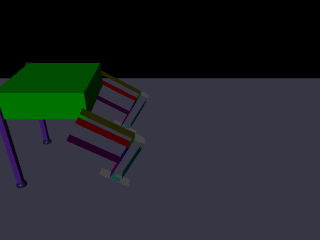

In [5]:
t,x,frames = runXML(ostrich_xml)

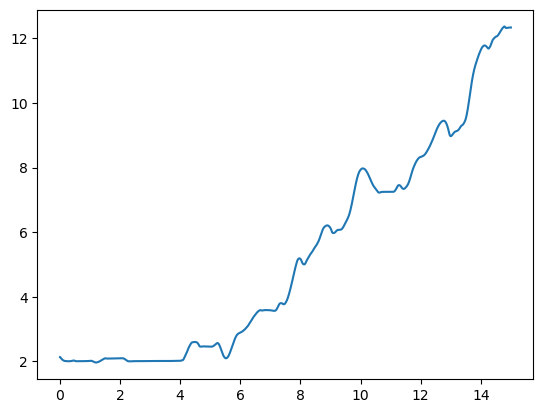

In [6]:
plt.plot(t, x)

In [7]:
servo_range = 3.2 # approximate pi range (180 degrees)
step = .3

off_set_list = []

for p1 in np.arange(0, servo_range, step):
    for p2 in np.arange(0, servo_range, step):
        for p3 in np.arange(0, servo_range, step):
            for p4 in np.arange(0, servo_range, step):
                off_set_list.append([p1, p2, p3, p4])

off_set_list
                

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.3],
 [0.0, 0.0, 0.0, 0.6],
 [0.0, 0.0, 0.0, 0.8999999999999999],
 [0.0, 0.0, 0.0, 1.2],
 [0.0, 0.0, 0.0, 1.5],
 [0.0, 0.0, 0.0, 1.7999999999999998],
 [0.0, 0.0, 0.0, 2.1],
 [0.0, 0.0, 0.0, 2.4],
 [0.0, 0.0, 0.0, 2.6999999999999997],
 [0.0, 0.0, 0.0, 3.0],
 [0.0, 0.0, 0.3, 0.0],
 [0.0, 0.0, 0.3, 0.3],
 [0.0, 0.0, 0.3, 0.6],
 [0.0, 0.0, 0.3, 0.8999999999999999],
 [0.0, 0.0, 0.3, 1.2],
 [0.0, 0.0, 0.3, 1.5],
 [0.0, 0.0, 0.3, 1.7999999999999998],
 [0.0, 0.0, 0.3, 2.1],
 [0.0, 0.0, 0.3, 2.4],
 [0.0, 0.0, 0.3, 2.6999999999999997],
 [0.0, 0.0, 0.3, 3.0],
 [0.0, 0.0, 0.6, 0.0],
 [0.0, 0.0, 0.6, 0.3],
 [0.0, 0.0, 0.6, 0.6],
 [0.0, 0.0, 0.6, 0.8999999999999999],
 [0.0, 0.0, 0.6, 1.2],
 [0.0, 0.0, 0.6, 1.5],
 [0.0, 0.0, 0.6, 1.7999999999999998],
 [0.0, 0.0, 0.6, 2.1],
 [0.0, 0.0, 0.6, 2.4],
 [0.0, 0.0, 0.6, 2.6999999999999997],
 [0.0, 0.0, 0.6, 3.0],
 [0.0, 0.0, 0.8999999999999999, 0.0],
 [0.0, 0.0, 0.8999999999999999, 0.3],
 [0.0, 0.0, 0.8999999999999999

run ostrich run

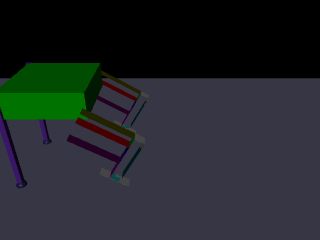

In [10]:
t,x,frames = runXML(ostrich_xml, off_set_list[0])

In [12]:
xs = []


for n, offs in enumerate(off_set_list):
    print(offs)
    
    t,x,frames = runXML(ostrich_xml, offs, render=False)
    max_x = x.max()
    xs.append([n, max_x])



[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.3]
[0.0, 0.0, 0.0, 0.6]
[0.0, 0.0, 0.0, 0.8999999999999999]
[0.0, 0.0, 0.0, 1.2]
[0.0, 0.0, 0.0, 1.5]
[0.0, 0.0, 0.0, 1.7999999999999998]
[0.0, 0.0, 0.0, 2.1]
[0.0, 0.0, 0.0, 2.4]
[0.0, 0.0, 0.0, 2.6999999999999997]
[0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.3, 0.0]
[0.0, 0.0, 0.3, 0.3]
[0.0, 0.0, 0.3, 0.6]
[0.0, 0.0, 0.3, 0.8999999999999999]
[0.0, 0.0, 0.3, 1.2]
[0.0, 0.0, 0.3, 1.5]
[0.0, 0.0, 0.3, 1.7999999999999998]
[0.0, 0.0, 0.3, 2.1]
[0.0, 0.0, 0.3, 2.4]
[0.0, 0.0, 0.3, 2.6999999999999997]
[0.0, 0.0, 0.3, 3.0]
[0.0, 0.0, 0.6, 0.0]
[0.0, 0.0, 0.6, 0.3]
[0.0, 0.0, 0.6, 0.6]
[0.0, 0.0, 0.6, 0.8999999999999999]
[0.0, 0.0, 0.6, 1.2]
[0.0, 0.0, 0.6, 1.5]
[0.0, 0.0, 0.6, 1.7999999999999998]
[0.0, 0.0, 0.6, 2.1]
[0.0, 0.0, 0.6, 2.4]
[0.0, 0.0, 0.6, 2.6999999999999997]
[0.0, 0.0, 0.6, 3.0]
[0.0, 0.0, 0.8999999999999999, 0.0]
[0.0, 0.0, 0.8999999999999999, 0.3]
[0.0, 0.0, 0.8999999999999999, 0.6]
[0.0, 0.0, 0.8999999999999999, 0.8999999999999999]
[0.0, 0.0, 0.

KeyboardInterrupt: 

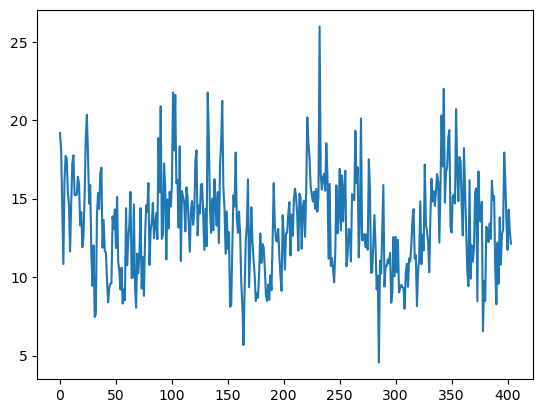

In [34]:
n_values, max_x_values = zip(*xs)

plt.plot(n_values, max_x_values)

In [36]:
max_x_overall = max(max_x_values)
max_x_index = n_values[max_x_values.index(max_x_overall)]

print(f"Maximum x value: {max_x_overall}")
print(f"Associated index: {max_x_index}")

Maximum x value: 25.9713603201725
Associated index: 232


run ostrich run

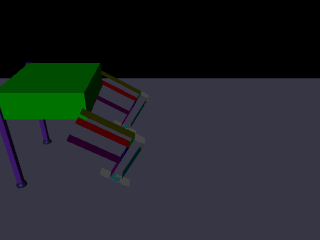

In [38]:
t,x,frames = runXML(ostrich_xml, off_set_list[max_x_index])

In [40]:
off_set_list[max_x_index]

[0.0, 0.3, 3.0, 0.3]